# Test the HALO Downstreaming Pipelines for regulation potential analysis

## Load the library

In [5]:
from typing import Dict, Iterable, Optional

import numpy as np
import torch
from torch.distributions import Normal, Poisson
from torch.distributions import kl_divergence as kld
from torch import tensor
import scanpy as sc
import anndata
import pandas as pd
import tools
import logging
import mira
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## You  might need to compute the Mira topic models for downstreaming tasks for Now

### If you need to train the MIRA model, see the downstream_pipeline_MIRA_topics.ipynb

## Load pretrained model

In [2]:
atac_model = mira.topics.AccessibilityTopicModel(counts_layer='counts',
                                                 dataset_loader_workers = 3)

rna_model = mira.topics.ExpressionTopicModel(
    endogenous_key='endog',
    exogenous_key='endog',
    counts_layer='counts',
    seed = 0,
    hidden=64, # to make the tutorial faster. In practice, use the default of 128!
)               

In [3]:
## The original data 
rna_data = anndata.read_h5ad("data/datasets/mouse_brain_rna_interim.h5ad")
atac_data =  anndata.read_h5ad("data/datasets/mouse_brain_atac_interim.h5ad")

/home/haiyi/anaconda3/envs/halo2/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


### You can also load the topic model predicted data


In [7]:
## you can also load the topic model predicted data
rna_data = anndata.read_h5ad("data/datasets/mouse_brain_rna_mira.h5ad")
atac_data =  anndata.read_h5ad("data/datasets/mouse_brain_atac_mira.h5ad")

In [8]:
rna_model = mira.topics.ExpressionTopicModel.load('MIRA/rna_topic_model.pth')
atac_model = mira.topics.AccessibilityTopicModel.load('MIRA/atac_topic_model.pth')

INFO:mira.topic_model.base:Moving model to CPU for inference.
INFO:mira.topic_model.base:Moving model to device: cpu
INFO:mira.topic_model.base:Moving model to CPU for inference.
INFO:mira.topic_model.base:Moving model to device: cpu


In [28]:
atac_data.obs.columns

Index(['celltype', 'batch_id', 'modality', 'latent_time', '_scvi_batch',
       '_scvi_labels', 'latent_decouple', 'latent_couple', 'latent_1',
       'latent_2', 'latent_3', 'latent_4', 'latent_5', 'latent_6', 'latent_7',
       'latent_8', 'latent_9', 'latent_10', 'topic_0', 'topic_1', 'topic_2',
       'topic_3', 'topic_4', 'topic_5', 'topic_6', 'topic_7', 'topic_8',
       'topic_9', 'topic_10', 'topic_11', 'topic_12', 'topic_13', 'topic_14',
       'softmax_denom'],
      dtype='object')

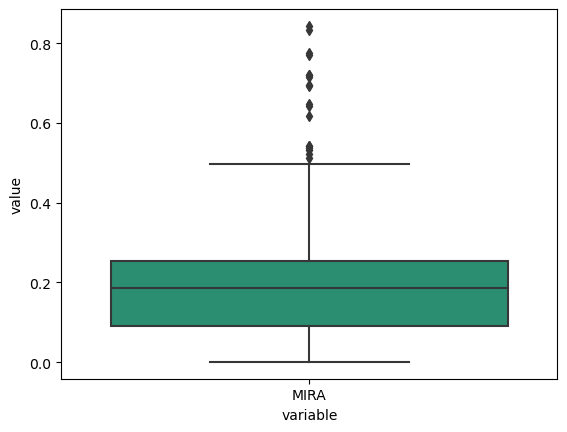

In [32]:
rna_latent = rna_data.obs[[ 'topic_0', 'topic_1',
       'topic_2', 'topic_3', 'topic_4', 'topic_5', 'topic_6', 'topic_7',
       'topic_8', 'topic_9', 'topic_10', 'topic_11', 'topic_12', 'topic_13',
       'topic_14']]
atac_latent = atac_data.obs[[ 'topic_0', 'topic_1', 'topic_2',
       'topic_3', 'topic_4', 'topic_5', 'topic_6', 'topic_7', 'topic_8',
       'topic_9', 'topic_10', 'topic_11', 'topic_12', 'topic_13', 'topic_14']]

df = pd.concat([rna_latent, atac_latent], axis=1)
correlation_matrix = df.corr()
correlation_matrix = correlation_matrix.iloc[np.arange(15), np.arange(15,30)]
df = pd.DataFrame({"variable": "MIRA", "value": np.abs(correlation_matrix.to_numpy().flatten())})
# lower_diagonal_values = lower_triangular_matrix.flatten()
ax = sns.boxplot(x='variable', y='value', data=df, palette="Dark2")

In [33]:
df.to_csv("figs/correlation_benchmark/mira_mouse_brain.csv")

## TSS Annotations

### annotate the rna data with Mouse model

In [ ]:
mira.tl.get_distance_to_TSS(atac_data,
                            tss_data='data/datasets/mm10_tss_data.bed12',
                            genome_file='data/datasets/mm10.chrom.sizes')

## Started the PR model

In [7]:
rp_args = dict(expr_adata = rna_data, atac_adata= atac_data)
rp_genes = ["ROBO1", "CTCF"]

In [8]:
litemodel = mira.rp.LITE_Model(expr_model = rna_model,
                              accessibility_model=atac_model,
                              counts_layer = 'counts',
                              genes = rp_genes)

In [9]:
## Fit the model
# litemodel.counts_layer = 'counts'
litemodel.fit(expr_adata=rna_data, atac_adata=atac_data, n_workers=4,  callback = mira.rp.SaveCallback("rpmodels/mira/"))

Fitting models: 100%|██████████| 2/2 [00:00<00:00, 17.18it/s]


In [18]:
rna_data

AnnData object with n_obs × n_vars = 3365 × 14583
    obs: 'celltype', 'batch_id', 'modality', 'latent_time', '_scvi_batch', '_scvi_labels'
    var: 'gene_ids', 'feature_types', 'modality', 'n_cells'

In [11]:
atac_data.var

,chr,start,end,n_cells,types
peak_id,,,,,
1,chr1,3094399,3095523,235,coupled
2,chr1,3113503,3114077,103,neither
3,chr1,3119414,3121804,449,neither
4,chr1,3198296,3198611,46,decoupled
5,chr1,3210204,3210605,52,neither
...,...,...,...,...,...
123879,GL456216.1,37994,39286,266,neither
123880,GL456216.1,40534,41810,139,coupled
123881,GL456216.1,49045,49376,35,neither
